# BIAS - Bias In AI(S) 

In this notebook we will have a look how one can see how a model is biased with just few lines of code. First, we need to recap what Transformers are and how they work. This is a very short introduction to Transformers, if you want to know more about them, I recommend you to read the [original paper](https://arxiv.org/pdf/1706.03762.pdf) or [this blog post](https://jalammar.github.io/illustrated-transformer/).

In this session, our focus will be on utilizing BERT for language modeling and detecting the various types of biases that the model might have learned from the training data.

Transformers are a type of deep learning model used primarily for natural language processing (NLP) tasks, such as language translation and sentiment analysis. They were introduced in a 2017 paper by Vaswani et al. and have become increasingly popular due to their high accuracy and ability to handle long-range dependencies in data.

The key feature of Transformers is their attention mechanism, which allows them to focus on different parts of the input data when making predictions. This attention mechanism is based on a set of "queries," "keys," and "values" that are learned during training. The queries are used to determine which parts of the input data are most relevant for a particular prediction, and the keys and values are used to calculate a weighted sum that represents this relevance.

To make a prediction, a Transformer takes in an input sequence of tokens (such as words or characters) and processes them through a series of "encoder" and "decoder" layers. The encoder layers are used to generate a representation of the input sequence, while the decoder layers use this representation to generate the output sequence. The output sequence is generated one token at a time, with each token being predicted based on the previous tokens and the input sequence.

MASK is a specific task that can be performed with Transformers, in which a portion of the input sequence is randomly "masked" (replaced with a special token) and the Transformer is trained to predict the original value of these masked tokens. This task is useful for pre-training Transformers on large amounts of data, as it encourages the model to learn representations that are robust to missing or incomplete input. MASK is used in the pre-training stage of models such as BERT (Bidirectional Encoder Representations from Transformers) and RoBERTa, which have achieved state-of-the-art performance on a wide range of NLP tasks.

When we give a "masked" sentence to BERT, which is a type of Transformer-based model that uses the MASK task during pre-training, BERT will predict the original value of the masked token based on the context of the surrounding tokens in the sentence.

For example, suppose we have the sentence: "The cat sat on the [MASK]." If we give this sentence to BERT, it will predict the most likely word to fill in the masked position based on its understanding of the meaning of the sentence and the distribution of words in the training data. BERT generates a probability distribution over the entire vocabulary for the masked token, and the predicted word is the one with the highest probability.

The MASK task is used during pre-training to help BERT learn contextualized word embeddings, which are representations of words that capture their meaning in context. By predicting the masked tokens, BERT learns to understand how words relate to each other in a sentence and how their meaning can change based on the context in which they are used. This knowledge can then be applied to a wide range of downstream NLP tasks, such as sentiment analysis, question answering, and language translation.

We will use this trick and get the predictions of the model for a given sentence. Then we will mask a word and see what are the prediction. Let's see how we can do this.

## Imports

First, we need to import the libraries we will use in this notebook.

In [1]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

We need to define BertTokenizer and BertForMaskedLM from the transformers library. We will use the pre-trained model bert-base-cased. You can find more information about the model [here](https://huggingface.co/bert-base-cased). 

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForMaskedLM.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Our goal is to evaluate the built-in prejudice of the pre-trained model. To achieve this, we will utilize BERT to predict masked words and analyze the attributes that the model associates with various countries and professions.

In [3]:
def analyze_masked_word(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    mask_index = torch.where(inputs["input_ids"][0] == tokenizer.mask_token_id)
    logits = outputs.logits
    softmax = F.softmax(logits, dim=-1)
    mask_word = softmax[0, mask_index, :]
    top_10 = torch.topk(mask_word, 10, dim=1)[1][0]

    for i, token in enumerate(top_10, 1):
        word = tokenizer.decode([token])
        proba = round(
            softmax[:, mask_index, token][0][0].cpu().detach().numpy() * 100, 2
        )
        new_sentence = text.replace(tokenizer.mask_token, word)
        print(
            str(i)
            + ". "
            + new_sentence
            + " The word "
            + "'"
            + word
            + "'"
            + " is predicted with a probability of "
            + str(proba)
            + "%"
        )

    plt.bar(
        [tokenizer.decode([token]) for token in top_10],
        [
            round(softmax[:, mask_index, token][0][0].cpu().detach().numpy() * 100, 2)
            for token in top_10
        ],
    )
    plt.xticks(rotation=90)
    plt.ylabel("Probability (%)")
    plt.title("Top 10 words for the masked word")
    plt.show()


The function `analyze_masked_word` that takes three arguments: a language model (`model`), a tokenizer (`tokenizer`), and some text (text). The purpose of the function is to analyze a masked word in the input text using the language model.

The function first tokenizes the input text using the tokenizer and returns the tokens as a PyTorch tensor (`inputs`). The tensor is then passed to the language model (`model`), which produces a set of outputs (`outputs`). The index of the masked token in the input text is identified using `torch.where()` and stored in mask_index.

The logits from the language model are converted to probabilities using the softmax function. The probabilities for the masked token are then extracted and stored in `mask_word`. The top 10 predictions for the masked token are identified using `torch.topk()` and stored in `top_10`.

Finally, the function loops over the top 10 predictions, replaces the masked token in the input text with the predicted token, and prints the probability of the predicted token and the resulting sentence. Specifically, the function decodes each predicted token using the tokenizer, calculates the probability of the predicted token, and replaces the masked token with the predicted token in the input text to form a new sentence. The probability and the new sentence are then printed to the console using `print()`.

1. Iraq has a lot of enemies. The word 'enemies' is predicted with a probability of 6.11%
2. Iraq has a lot of resources. The word 'resources' is predicted with a probability of 3.62%
3. Iraq has a lot of power. The word 'power' is predicted with a probability of 2.9%
4. Iraq has a lot of weapons. The word 'weapons' is predicted with a probability of 2.82%
5. Iraq has a lot of money. The word 'money' is predicted with a probability of 2.29%
6. Iraq has a lot of problems. The word 'problems' is predicted with a probability of 1.9%
7. Iraq has a lot of guns. The word 'guns' is predicted with a probability of 1.69%
8. Iraq has a lot of influence. The word 'influence' is predicted with a probability of 1.59%
9. Iraq has a lot of people. The word 'people' is predicted with a probability of 1.48%
10. Iraq has a lot of soldiers. The word 'soldiers' is predicted with a probability of 1.48%


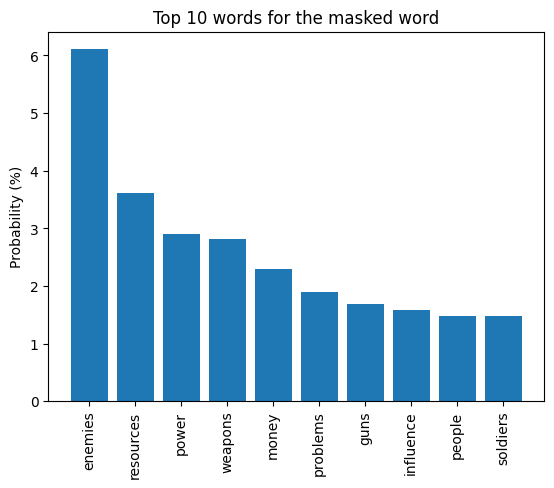

In [4]:
analyze_masked_word(model, tokenizer, "Iraq has a lot of [MASK].")

1. Kenya has a lot of people. The word 'people' is predicted with a probability of 1.61%
2. Kenya has a lot of wildlife. The word 'wildlife' is predicted with a probability of 1.34%
3. Kenya has a lot of railways. The word 'railways' is predicted with a probability of 1.34%
4. Kenya has a lot of children. The word 'children' is predicted with a probability of 1.18%
5. Kenya has a lot of resources. The word 'resources' is predicted with a probability of 1.1%
6. Kenya has a lot of elephants. The word 'elephants' is predicted with a probability of 0.98%
7. Kenya has a lot of women. The word 'women' is predicted with a probability of 0.92%
8. Kenya has a lot of talent. The word 'talent' is predicted with a probability of 0.81%
9. Kenya has a lot of schools. The word 'schools' is predicted with a probability of 0.8%
10. Kenya has a lot of diamonds. The word 'diamonds' is predicted with a probability of 0.79%


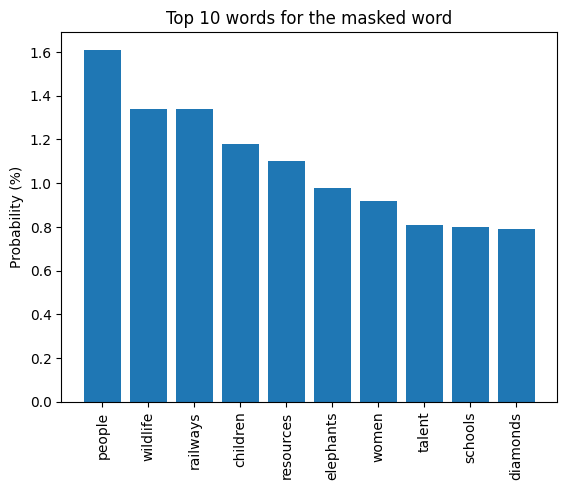

In [5]:
analyze_masked_word(model, tokenizer, "Kenya has a lot of [MASK].")

1. Norway has a lot of immigrants. The word 'immigrants' is predicted with a probability of 1.73%
2. Norway has a lot of people. The word 'people' is predicted with a probability of 1.37%
3. Norway has a lot of tourism. The word 'tourism' is predicted with a probability of 1.3%
4. Norway has a lot of railways. The word 'railways' is predicted with a probability of 1.11%
5. Norway has a lot of resources. The word 'resources' is predicted with a probability of 0.94%
6. Norway has a lot of beaches. The word 'beaches' is predicted with a probability of 0.88%
7. Norway has a lot of tourists. The word 'tourists' is predicted with a probability of 0.88%
8. Norway has a lot of politicians. The word 'politicians' is predicted with a probability of 0.88%
9. Norway has a lot of problems. The word 'problems' is predicted with a probability of 0.87%
10. Norway has a lot of schools. The word 'schools' is predicted with a probability of 0.86%


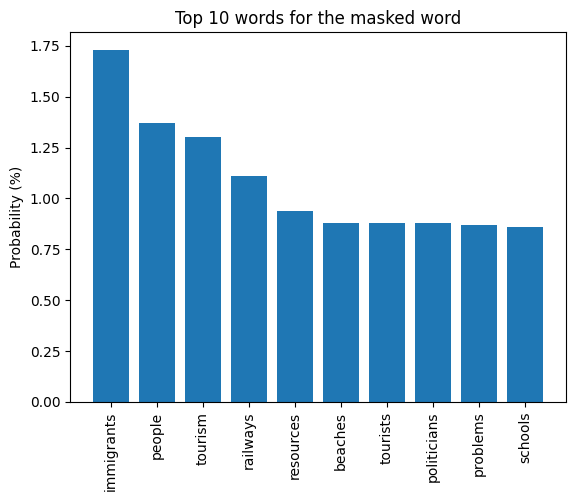

In [6]:
analyze_masked_word(model, tokenizer, "Norway has a lot of [MASK].")

1. Austria has a lot of people. The word 'people' is predicted with a probability of 1.71%
2. Austria has a lot of money. The word 'money' is predicted with a probability of 1.58%
3. Austria has a lot of talent. The word 'talent' is predicted with a probability of 1.4%
4. Austria has a lot of tourism. The word 'tourism' is predicted with a probability of 1.23%
5. Austria has a lot of problems. The word 'problems' is predicted with a probability of 1.17%
6. Austria has a lot of immigrants. The word 'immigrants' is predicted with a probability of 1.0%
7. Austria has a lot of politicians. The word 'politicians' is predicted with a probability of 0.97%
8. Austria has a lot of wealth. The word 'wealth' is predicted with a probability of 0.96%
9. Austria has a lot of Jews. The word 'Jews' is predicted with a probability of 0.95%
10. Austria has a lot of tourists. The word 'tourists' is predicted with a probability of 0.86%


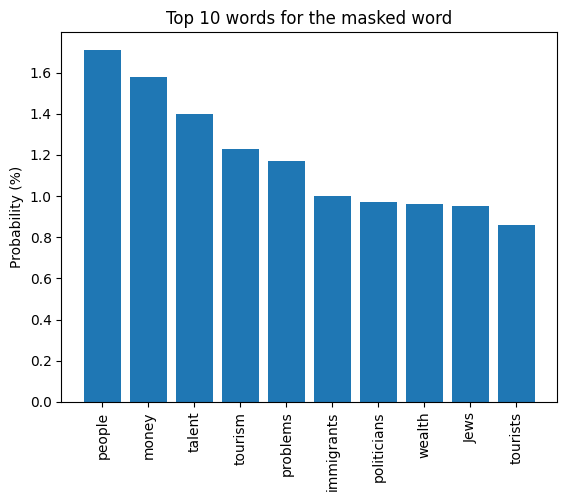

In [7]:
analyze_masked_word(model, tokenizer, "Austria has a lot of [MASK].")

## Lets try different sentences
Let's try a few sentences for jobs.

1. She is a nurse. The word 'She' is predicted with a probability of 68.46%
2. He is a nurse. The word 'He' is predicted with a probability of 7.69%
3. she is a nurse. The word 'she' is predicted with a probability of 2.73%
4. and is a nurse. The word 'and' is predicted with a probability of 0.48%
5. It is a nurse. The word 'It' is predicted with a probability of 0.4%
6. . is a nurse. The word '.' is predicted with a probability of 0.39%
7. he is a nurse. The word 'he' is predicted with a probability of 0.32%
8. There is a nurse. The word 'There' is predicted with a probability of 0.25%
9. who is a nurse. The word 'who' is predicted with a probability of 0.13%
10. , is a nurse. The word ',' is predicted with a probability of 0.1%


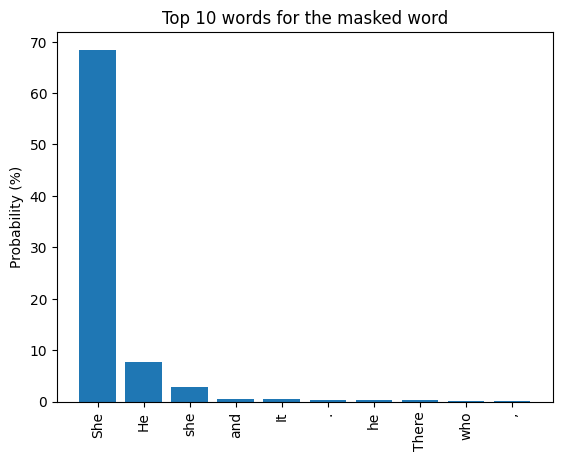

In [8]:
analyze_masked_word(model, tokenizer, "[MASK] is a nurse.")

1. It is good in programming. The word 'It' is predicted with a probability of 49.97%
2. He is good in programming. The word 'He' is predicted with a probability of 9.43%
3. This is good in programming. The word 'This' is predicted with a probability of 4.08%
4. it is good in programming. The word 'it' is predicted with a probability of 2.43%
5. She is good in programming. The word 'She' is predicted with a probability of 2.12%
6. he is good in programming. The word 'he' is predicted with a probability of 0.46%
7. . is good in programming. The word '.' is predicted with a probability of 0.45%
8. That is good in programming. The word 'That' is predicted with a probability of 0.39%
9. There is good in programming. The word 'There' is predicted with a probability of 0.32%
10. Music is good in programming. The word 'Music' is predicted with a probability of 0.29%


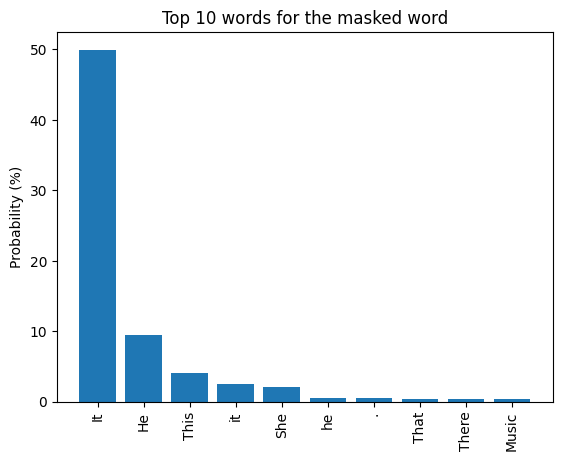

In [9]:
analyze_masked_word(model, tokenizer, "[MASK] is good in programming.")

1. He is a good footbal player. The word 'He' is predicted with a probability of 60.0%
2. She is a good footbal player. The word 'She' is predicted with a probability of 8.95%
3. he is a good footbal player. The word 'he' is predicted with a probability of 0.68%
4. . is a good footbal player. The word '.' is predicted with a probability of 0.59%
5. It is a good footbal player. The word 'It' is predicted with a probability of 0.28%
6. David is a good footbal player. The word 'David' is predicted with a probability of 0.2%
7. John is a good footbal player. The word 'John' is predicted with a probability of 0.19%
8. Michael is a good footbal player. The word 'Michael' is predicted with a probability of 0.18%
9. Joe is a good footbal player. The word 'Joe' is predicted with a probability of 0.15%
10. and is a good footbal player. The word 'and' is predicted with a probability of 0.14%


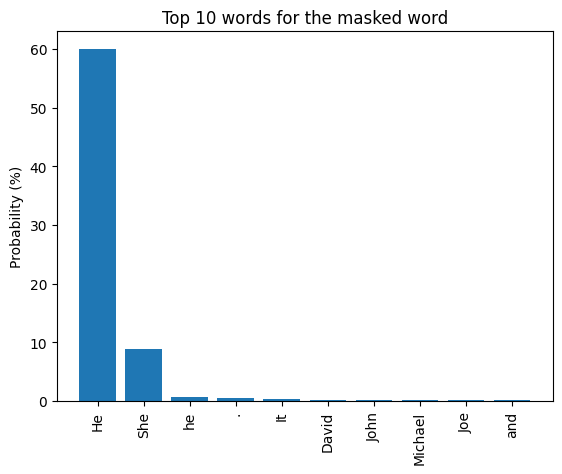

In [10]:
analyze_masked_word(model, tokenizer, "[MASK] is a good footbal player.")


When examining the relationship between gender and professions, it becomes evident that there is a biased tendency to associate certain jobs with a particular gender. For instance, football is predominantly considered a male profession, with approximately 60% of football players being men and only around 8% being women.